## Lab 3

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import string
import re
import time
import torch
import typing

In [10]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [11]:
 # Флаг для тестирование и запуска
DEBUG = False

## **Data loading**

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [12]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

max length = 63


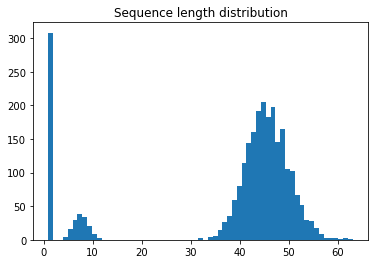

In [13]:
MAX_LENGTH = max(map(len, text))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
hist = plt.hist(list(map(len, text)),bins=MAX_LENGTH)

All lines from text less than 10 characters in length serve as auxiliary information in the source.

## **Dictionary generation.**

In [18]:
# предобработка текста
def replace(sentence, blacklist: str=string.digits+string.punctuation):
      for char in blacklist:
          sentence = sentence.translate({ord(char): None})
      return sentence

def refactor(text, len_thresholds: typing.Tuple[int, int]=(30, MAX_LENGTH), blacklist: str=string.digits+string.punctuation) -> str:
    src_len, res_len = len_thresholds
    return [
        replace(sentence.lstrip().lower(), blacklist)  
        for sentence in text
        if src_len <= len(sentence) <= res_len
    ]

text = refactor(text)

In [21]:
# Переведем все буквы в токены.
tokens = set("".join(text))

# будем использовать пробел как <pad> 
tokens.add('<pad>')

tokens = sorted(list(tokens))
num_tokens = len(tokens)

In [24]:
# Создадим словари: `token_to_idx = {<char>: <index>}` и `idx_to_token = {<index>: <char>}`.
idx_to_token = dict(list(enumerate(tokens)))
token_to_idx = dict([(token, idx) for idx, token in idx_to_token.items()])

# Проверка на равенство размеров словарей
assert len(idx_to_token) == len(token_to_idx)

# Проверим своего рода "биекцию" словарей
for i in range(max(len(idx_to_token), len(token_to_idx))):
    assert token_to_idx[idx_to_token[i]] == i

In [25]:
PAD_IDX = token_to_idx['<pad>']

In [27]:
# Шекспир использовал все буквы английского алфавита)
token_to_idx

{'\n': 0,
 ' ': 1,
 '<pad>': 2,
 'a': 3,
 'b': 4,
 'c': 5,
 'd': 6,
 'e': 7,
 'f': 8,
 'g': 9,
 'h': 10,
 'i': 11,
 'j': 12,
 'k': 13,
 'l': 14,
 'm': 15,
 'n': 16,
 'o': 17,
 'p': 18,
 'q': 19,
 'r': 20,
 's': 21,
 't': 22,
 'u': 23,
 'v': 24,
 'w': 25,
 'x': 26,
 'y': 27,
 'z': 28}

## **Data preprocessing.**

In [68]:
# Перевод токена в буквы
def word_from_tokens(tokens: str) -> np.array:
     return np.array([token_to_idx[token] for token in tokens])

# Перевод уже в предложения 
def sentectence_to_tokens(batch: typing.List[str]) -> np.array:
    return np.concatenate(list(map(word_from_tokens, batch)))

In [78]:
# Сводим (сжимаем/растягиваем) к единому размеру
def shape_text(text: typing.List[str], max_tokens_len: int):
    joined_text = " ".join(text)
    n_tokens = len(joined_text) // max_tokens_len
    reshaped_text = []
    for i in range(0, n_tokens * max_tokens_len, max_tokens_len):
        reshaped_text.append(joined_text[i:i+max_tokens_len])
    return reshaped_text

In [83]:
# Переводим предложения в матрицы для RNN
def to_matrix(text: typing.List[str], max_len: int=None, pad: int=PAD_IDX, dtype: str='int32', batch_first: bool=True):
    size = max_len or max(map(len, text))
    matrix = np.zeros([len(text), size], dtype) + pad
    for i in range(len(text)):
        line_ix = sentectence_to_tokens([text[i]])
        matrix[i, :len(line_ix)] = line_ix
    if not batch_first:
        matrix = np.transpose(matrix)
    return torch.tensor(matrix, dtype=torch.int64)

In [66]:
from pprint import pprint

pprint(text[:5])
transformed_text = to_matrix(text[:5])
pprint(transformed_text)

['from fairest creatures we desire increase\n',
 'that thereby beautys rose might never die\n',
 'but as the riper should by time decease\n',
 'his tender heir might bear his memory\n',
 'but thou contracted to thine own bright eyes\n']
tensor([[ 8, 20, 17, 15,  1,  8,  3, 11, 20,  7, 21, 22,  1,  5, 20,  7,  3, 22,
         23, 20,  7, 21,  1, 25,  7,  1,  6,  7, 21, 11, 20,  7,  1, 11, 16,  5,
         20,  7,  3, 21,  7,  0,  2,  2,  2],
        [22, 10,  3, 22,  1, 22, 10,  7, 20,  7,  4, 27,  1,  4,  7,  3, 23, 22,
         27, 21,  1, 20, 17, 21,  7,  1, 15, 11,  9, 10, 22,  1, 16,  7, 24,  7,
         20,  1,  6, 11,  7,  0,  2,  2,  2],
        [ 4, 23, 22,  1,  3, 21,  1, 22, 10,  7,  1, 20, 11, 18,  7, 20,  1, 21,
         10, 17, 23, 14,  6,  1,  4, 27,  1, 22, 11, 15,  7,  1,  6,  7,  5,  7,
          3, 21,  7,  0,  2,  2,  2,  2,  2],
        [10, 11, 21,  1, 22,  7, 16,  6,  7, 20,  1, 10,  7, 11, 20,  1, 15, 11,
          9, 10, 22,  1,  4,  7,  3, 20,  1, 10, 11, 21,  

In [69]:
N_EPOCHS_DEBUG = 16
N_EPOCHS_RELEASE = 512
N_EPOCHS = N_EPOCHS_DEBUG if DEBUG else N_EPOCHS_RELEASE

## **Model (neural network) training: Vanilla**

Начнем с  `vanilla RNN`, большуя часть кода взяв в семинара.

In [70]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [71]:
def plot_loss(losses: list, title: str=None):
    fig = plt.figure(figsize=(15, 10))
    if title is not None:
        plt.title(title)
    plt.plot(losses)
    plt.ylabel('Loss')
    plt.xlabel('Epoch #')
    plt.show()

In [73]:
# Из семинара
class VanillaCharRNN(nn.Module):
   
    def __init__(
        self,
        num_tokens: int=len(tokens),
        embedding_size: int=64,
        rnn_num_units: int=128
    ):
        super(VanillaCharRNN, self).__init__()
        self.rnn_num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn = nn.RNN(embedding_size, rnn_num_units, batch_first=True)
        self.linear = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        out, h_next = self.rnn(x_emb, h_prev)
        logits = self.linear(out)
        return h_next, logits
    
    def initial_state(self, batch_size):
        return torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=True)

In [75]:
def rnn_epoch(model, hidden_state, all_batches, batch_size):
    global PAD_IDX
    n_batches = all_batches.shape[0] // batch_size
    loss = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    epoch_loss = 0.0

    for i in range(0, n_batches * batch_size, batch_size):
        batch_ix = all_batches[i:i+batch_size]
        hidden_state, out = model(batch_ix, hidden_state)
        actual_next_tokens = batch_ix[:, 1:]

        batch_loss = loss(out[:, :-1].reshape(-1, len(tokens)), actual_next_tokens.reshape(-1))
        batch_loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        epoch_loss += batch_loss.item()
        hidden_state.detach_()
        hidden_state = hidden_state.detach()

    epoch_loss /= n_batches
    return hidden_state, epoch_loss

In [81]:
def train(model: nn.Module, n_epochs: int=16, optimizer=None, max_tokens_len: int=MAX_LENGTH-3, batch_size: int=10):
    losses = []
    # Привели к единому размеру
    shaped_text = shape_text(text, max_tokens_len)
    # Перевели в матрицу
    all_batches = to_matrix(shaped_text, max_tokens_len)
    # Поехали
    state = model.initial_state(batch_size)

    for epoch in range(n_epochs):
        print("{}-st epoch of {}".format(epoch + 1, n_epochs))
        state, epoch_loss = rnn_epoch(model, state, all_batches, batch_size)
        losses.append(epoch_loss)

    return losses, state

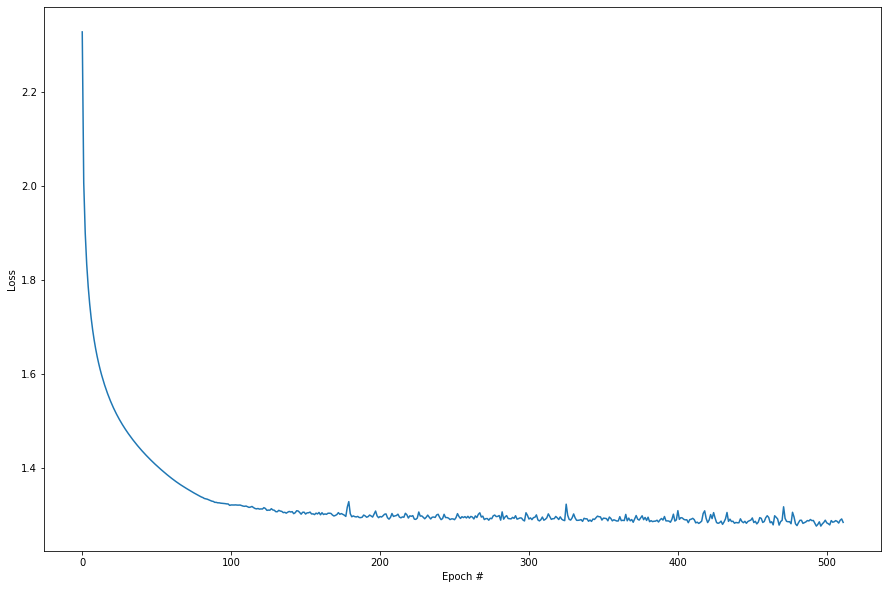

In [85]:
model = VanillaCharRNN()
optimizer = torch.optim.Adam(model.parameters())
vanilla_losses, vanilla_state = train(model, N_EPOCHS, optimizer)
plot_loss(vanilla_losses)

## **Text generation (model evaluation): Vanilla**

In [86]:
def generate_sample(model, seed_phrase=' ', max_length=400, temperature=1.0):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.long)
    states = model.initial_state(batch_size=1)
    
    for i in range(len(seed_phrase) - 1):
        states, _ = model(x_sequence[:, :, i], states)

    for _ in range(max_length - len(seed_phrase)):
        states, out = model(x_sequence[:,:, -1], states)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0].ravel()
        
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[[next_ix]]], dtype=torch.long)
        x_sequence = torch.cat([x_sequence, next_ix], dim=2)
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [87]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f"\n\tTemperature: {t}")
    print(generate_sample(model, seed_phrase="love death", temperature=t))


	Temperature: 0.1
love death the fair in the world with my strenge
 the world with my self it is thou art to the world where is the state
 the world where is the store
 the world where is my love is the state
 the world where is the state
 the world where is the story then in thee that is the world with my love is the story then in the world where is the world with my state
 the world where is my love is thy self i

	Temperature: 0.2
love death the lovd the world where is my love thee with my stores the world with the world where is thy self it the in the world with my strenge
 the in the world where is the state
 the willing spend
 and the in the world with the world with well
 that i am not be my strenge
 the world where is my self and thou shouldst the star what thou mayst thou mayst he will thou art the world where is the 

	Temperature: 0.5
love death inconstant consider sweet soul looks to the still cank seeing
 and i will hold no more
 but despen
 in other my love is thou art
 

Увеличение параметра провоцирует менее связный выход.

## **Model (neural network) training: LSTM**

In [88]:
class LSTMCharRNN(nn.Module):

    def __init__(self, num_tokens: int=len(tokens), embedding_size: int=64, rnn_num_units: int=128):
        super(LSTMCharRNN, self).__init__()
        self.rnn_num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(embedding_size, rnn_num_units, batch_first=True)
        self.linear = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, states=None):
        x_emb = self.embedding(x)
        if states is None:
            states = initial_state(1)
        out, states = self.lstm(x_emb, states)
        
        logits = self.linear(out)
        return states, logits
    
    def initial_state(self, batch_size) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        return (
            torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=True),
            torch.zeros(1, batch_size, self.rnn_num_units, requires_grad=True)
        )

In [89]:
def rnn_epoch_lstm(model, states, all_batches, batch_size):
    global PAD_IDX
    n_batches = all_batches.shape[0] // batch_size
    loss = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    epoch_loss = 0.0

    for i in range(0, n_batches * batch_size, batch_size):
        batch_ix = all_batches[i:i+batch_size]
        states, out = model(batch_ix, states)
        hidden_state, cell_state = states
        actual_next_tokens = batch_ix[:, 1:]

        batch_loss = loss(out[:, :-1].reshape(-1, len(tokens)), actual_next_tokens.reshape(-1))
        batch_loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += batch_loss.item()

        hidden_state.detach_()
        hidden_state = hidden_state.detach()

        cell_state.detach_()
        cell_state = cell_state.detach()

        states = hidden_state, cell_state
        
    epoch_loss /= n_batches
    return states, epoch_loss

Epoch 1 of 512
Epoch 2 of 512
Epoch 3 of 512
Epoch 4 of 512
Epoch 5 of 512
Epoch 6 of 512
Epoch 7 of 512
Epoch 8 of 512
Epoch 9 of 512
Epoch 10 of 512
Epoch 11 of 512
Epoch 12 of 512
Epoch 13 of 512
Epoch 14 of 512
Epoch 15 of 512
Epoch 16 of 512
Epoch 17 of 512
Epoch 18 of 512
Epoch 19 of 512
Epoch 20 of 512
Epoch 21 of 512
Epoch 22 of 512
Epoch 23 of 512
Epoch 24 of 512
Epoch 25 of 512
Epoch 26 of 512
Epoch 27 of 512
Epoch 28 of 512
Epoch 29 of 512
Epoch 30 of 512
Epoch 31 of 512
Epoch 32 of 512
Epoch 33 of 512
Epoch 34 of 512
Epoch 35 of 512
Epoch 36 of 512
Epoch 37 of 512
Epoch 38 of 512
Epoch 39 of 512
Epoch 40 of 512
Epoch 41 of 512
Epoch 42 of 512
Epoch 43 of 512
Epoch 44 of 512
Epoch 45 of 512
Epoch 46 of 512
Epoch 47 of 512
Epoch 48 of 512
Epoch 49 of 512
Epoch 50 of 512
Epoch 51 of 512
Epoch 52 of 512
Epoch 53 of 512
Epoch 54 of 512
Epoch 55 of 512
Epoch 56 of 512
Epoch 57 of 512
Epoch 58 of 512
Epoch 59 of 512
Epoch 60 of 512
Epoch 61 of 512
Epoch 62 of 512
Epoch 63 of 512
E

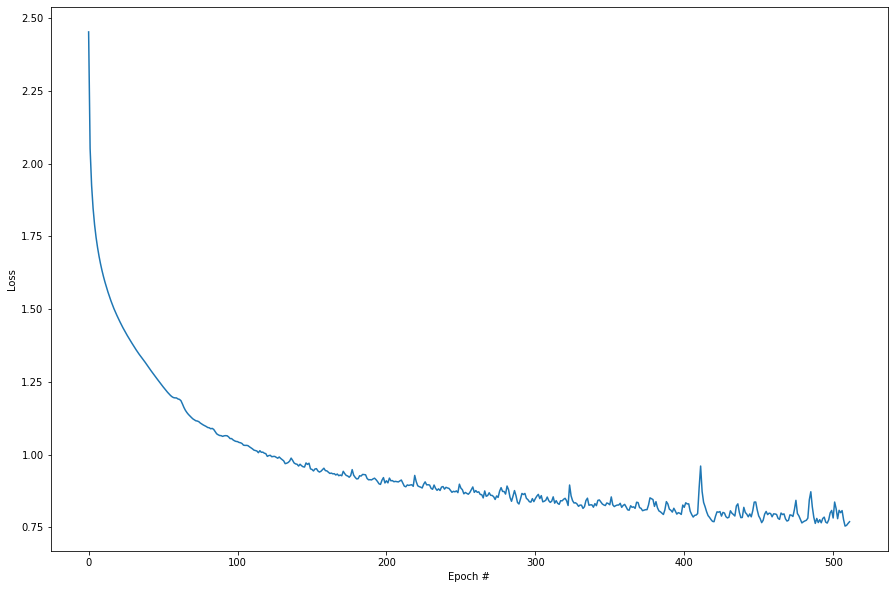

In [91]:
lstm_model = LSTMCharRNN()
optimizer = torch.optim.Adam(lstm_model.parameters())

lstm_losses, lstm_states = train(lstm_model, N_EPOCHS, optimizer)
plot_loss(lstm_losses)

## **Text generation (model evaluation): LSTM**

In [94]:
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f"\n\tTemperature: {t}")
    print(generate_sample(lstm_model, seed_phrase="love death", temperature=t))


	Temperature: 0.1
love death that i do more
 that he is but the strent to most my love to the worlds to their brow
 and deadst the world may still strain in my heart
 which thy worsh my friend have eyes so blamd
 for as as my true like to have thou mayst tooks my love shall the world is one
 so thy will
 and may state
 and therefore myself i bright make my mind no part
 the buds to say that thou thyself doth use my

	Temperature: 0.2
love death that i do no poor now
 that if i h may i not then they her storn
 so that thou thyself is great begar is thou art myself i bring the pride
 and in my heart which thou art the seas and thou like sland
 to say mine own some prousting thy breathes to makes of your neer love in thee
 the heart that sweet ornament of many heal have remove
 for throw leavst that thy sweet semblance to set me 

	Temperature: 0.5
love deaths be that i know should behold against myself but to the most thou lovst thou art
 who have pride much in the write d say my love t

Как и следовало ожидать, LSTM показывает лучший результат.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [95]:
# Saving and loading code here
torch.save(lstm_model.state_dict(), 'lstm_sonnet.pth')

In [96]:
new_lstm_model = LSTMCharRNN()
new_lstm_model.load_state_dict(torch.load('lstm_sonnet.pth'))
new_lstm_model.eval()

LSTMCharRNN(
  (embedding): Embedding(29, 64, padding_idx=2)
  (lstm): LSTM(64, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=29, bias=True)
)

In [97]:
print(generate_sample(new_lstm_model, max_length=100, temperature=0.75))

 babe do clake
 as thou consumps with thy outward pride their dead
 the chir seald thy will
 and wil
